In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Recebendo inputs do kaggle e separando em pastas

Importando dependências

In [14]:
# Importe pacotes

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import shutil

In [15]:
# Caminhos para as pastas
train_color_dir = "data/original/train"
train_label_dir = "data/conditional/train_labels"
val_color_dir = "data/original/val"
val_label_dir = "data/conditional/val_labels"
test_color_dir = "data/original/test"
test_label_dir = "data/conditional/test_labels"

In [16]:
# Listar imagens (assumindo que os pares têm o mesmo nome de arquivo)
train_color_images = sorted(os.listdir(train_color_dir))
val_color_images = sorted(os.listdir(val_color_dir))
test_color_images = sorted(os.listdir(test_color_dir))

train_label_images = sorted(os.listdir(train_label_dir))
val_label_images = sorted(os.listdir(val_label_dir))
test_label_images = sorted(os.listdir(test_label_dir))

# Extraindo nomes dos arquivos (sem a extensão)
train_names = [os.path.splitext(img)[0] for img in train_color_images]
val_names = [os.path.splitext(img)[0] for img in val_color_images]
test_names = [os.path.splitext(img)[0] for img in test_color_images]

train_names_labels = [os.path.splitext(img)[0] for img in train_label_images]
val_names_labels = [os.path.splitext(img)[0] for img in val_label_images]
test_names_labels = [os.path.splitext(img)[0] for img in test_label_images]




Preparando imagens

In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Definindo transformações para as imagens
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona as imagens para um tamanho fixo
    transforms.ToTensor()  # Converte as imagens para tensores
])

# Classe customizada para carregar as imagens
class CustomDataset(Dataset):
    def __init__(self, label_dir, color_dir, image_names, label_names, transform=None):
        self.label_dir = label_dir
        self.color_dir = color_dir
        self.image_names = image_names
        self.label_names = label_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        label_image_path = os.path.join(self.label_dir, f"{self.label_names[idx]}.png")
        color_image_path = os.path.join(self.color_dir, f"{self.image_names[idx]}.png")

        label_image = Image.open(label_image_path).convert("RGB")
        color_image = Image.open(color_image_path).convert("RGB")

        if self.transform:
            label_image = self.transform(label_image)
            color_image = self.transform(color_image)

        return label_image, color_image

# Criando datasets
train_dataset = CustomDataset(train_label_dir, train_color_dir, train_names, train_names_labels, transform=transform)
val_dataset = CustomDataset(val_label_dir, val_color_dir, val_names, val_names_labels, transform=transform)
test_dataset = CustomDataset(test_label_dir, test_color_dir, test_names, test_names_labels, transform=transform)

# Criando DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

print("DataLoaders criados com sucesso!")

DataLoaders criados com sucesso!


Definindo Gerador

In [18]:
# U-Net

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, image_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1):
        super(UNet, self).__init__()

        self.image_dim = image_dim  # Dimensões da imagem de entrada (C, H, W)
        self.depth = depth 
        self.n_channels = n_channels
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding
        self.transpose_kernel_size = transpose_kernel_size
        self.transpose_stride = transpose_stride
        self.transpose_padding = transpose_padding

        # Encoder
        self.encoders = nn.ModuleList([self.conv_block(3 if i == 0 else self.n_channels * (2 ** (i-1)), self.n_channels * (2 ** i)) for i in range(self.depth)])
        self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)

        # Bottleneck
        self.bottleneck = self.conv_block(self.n_channels * (2 ** (self.depth-1)), self.n_channels * (2 ** self.depth))

        # Decoder
        self.decoders = nn.ModuleList([self.conv_transpose(self.n_channels * (2 ** (i+2)), self.n_channels * (2 ** i)) for i in range(self.depth-2, -1, -1)])

        # Final conv layer
        self.final_conv = nn.Conv2d(self.n_channels, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # Camada convolucional com normalização e função de ativação; 2 vezes
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),  # Normalização para acelerar o treinamento
            nn.ReLU(inplace=True),  # Função de ativação (zera os valores negativos)
            nn.Conv2d(out_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop(self, encoder_feature, decoder_feature):
        _, _, h, w = decoder_feature.size()
        encoder_feature = F.interpolate(encoder_feature, size=(h, w), mode='bilinear', align_corners=False)  # Redimensiona a feature map do encoder
        return encoder_feature

    def conv_transpose(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.transpose_kernel_size, stride=self.transpose_stride, padding=self.transpose_padding),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        encoders_features = []

        # Encoder pass
        for idx, encoder in enumerate(self.encoders):
            #print("idx: ", idx)
            #print("encoder: ", encoder)
            x = encoder(x)
            encoders_features.append(x)
            #print(f"After encoder block {idx+1}: {x.shape}")
            x = self.pool(x)
            #print(f"After pooling {idx+1}: {x.shape}")

        # Bottleneck
        x = self.bottleneck(x)
        #print(f"After bottleneck: {x.shape}")
        # Doubled the block
        #print("Starting decoder pass")
        # Decoder pass
        for i, decoder in enumerate(self.decoders):
            #print("i: ", i)
            #print("decoder: ", decoder)
            encoder_feature = encoders_features[-(i+1)]
            encoder_feature = self.crop(encoder_feature, x)  # Aplica o crop nas feature maps
            #print(f"Encoder feature {i+1} after crop: {encoder_feature.shape}")

            if i != 0:
                x = torch.cat([encoder_feature, x], dim=1)  # Concatena encoder com decoder
                #print(f"After concatenation with encoder feature {i+1}: {x.shape}")

            x = decoder(x)

        # Final convolution
        x = self.final_conv(x)
        x = F.interpolate(x, size=(self.image_dim[2], self.image_dim[3]), mode='bilinear', align_corners=False)
        #print(f"Output shape after final convolution: {x.shape}")
        
        x = torch.sigmoid(x)
        
        return x

Testando gerador

Gerador gera uma imagem do tamanho desejado, passando pela unet

Discriminador

In [19]:

class Discriminator(nn.Module):
    def __init__(self, image_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1):
        super().__init__()

        self.image_dim = image_dim  # Dimensões da imagem de entrada (C, H, W)
        self.depth = depth 
        self.n_channels = n_channels
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding
        self.transpose_kernel_size = transpose_kernel_size
        self.transpose_stride = transpose_stride
        self.transpose_padding = transpose_padding

        # Encoder
        self.encoders = nn.ModuleList([self.conv_block(3 if i == 0 else self.n_channels * (2 ** (i-1)), self.n_channels * (2 ** i)) for i in range(self.depth)])
        self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)

        # Bottleneck
        self.bottleneck = self.conv_block(self.n_channels * (2 ** (self.depth-1)), self.n_channels * (2 ** self.depth))

        # Final conv layer
        self.final_conv = nn.Conv2d(self.n_channels * (2 ** self.depth), 1, kernel_size=1)

        # Fully connected layer to reduce the dimensions to [32, 1, 1, 1]
        self.fc = nn.Linear(self.image_dim[2] * self.image_dim[3], 1)

    def conv_block(self, in_channels, out_channels):
        # Camada convolucional com normalização e função de ativação; 2 vezes
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),  # Normalização para acelerar o treinamento
            nn.ReLU(inplace=True)  # Função de ativação (zera os valores negativos)
        )
    
        """
            nn.Conv2d(out_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        """

    def crop(self, encoder_feature, decoder_feature):
        _, _, h, w = decoder_feature.size()
        encoder_feature = F.interpolate(encoder_feature, size=(h, w), mode='bilinear', align_corners=False)  # Redimensiona a feature map do encoder
        return encoder_feature

    def conv_transpose(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.transpose_kernel_size, stride=self.transpose_stride, padding=self.transpose_padding),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        encoders_features = []

        # Encoder pass
        for idx, encoder in enumerate(self.encoders):
            #print("idx: ", idx)
            #print("encoder: ", encoder)
            x = encoder(x)
            encoders_features.append(x)
            #print(f"After encoder block {idx+1}: {x.shape}")
            x = self.pool(x)
            #print(f"After pooling {idx+1}: {x.shape}")

        # Bottleneck
        x = self.bottleneck(x)
        #print(f"After bottleneck: {x.shape}")
        # Doubled the block
        #print("Starting decoder pass")

        # Final convolution
        x = self.final_conv(x)
        x = F.interpolate(x, size=(1, 1), mode='bilinear', align_corners=False)
        #print(f"Output shape after final convolution: {x.shape}")
        x = torch.sigmoid(x)


        return x

Treino

In [20]:
from torch.optim import Adam, SGD
from torch.nn import BCELoss, L1Loss, MSELoss
import time

# Loss para o discriminador
d_loss = BCELoss()

class GeneratorLoss(nn.Module):
    def __init__(self, lambda_l1=100):
        super(GeneratorLoss, self).__init__()
        # Definir a perda BCE (usada para a parte adversária)
        self.adversarial_loss = nn.MSELoss()
        # Definir a perda L1
        self.l1_loss = nn.L1Loss()
        # Peso da perda L1
        self.lambda_l1 = lambda_l1

    def forward(self, yhat_fake, fake_images, real_images):
        """
        Parâmetros:
        - yhat_fake: As previsões do discriminador sobre as imagens geradas (fake)
        - fake_images: Imagens geradas pelo gerador
        - real_images: Imagens reais de referência
        
        Retorna:
        - A perda total combinando perda adversária e L1
        """
        # Perda adversária: tentar fazer o discriminador acreditar que as imagens geradas são reais
        adversarial_loss = self.adversarial_loss(yhat_fake, torch.ones_like(yhat_fake))
        
        # Perda L1: minimizar a diferença entre as imagens geradas e as reais
        l1_loss = self.l1_loss(fake_images, real_images)
        
        # Perda total: adversária + ponderação da perda L1
        total_loss = adversarial_loss + self.lambda_l1 * l1_loss
        
        return total_loss

g_loss = GeneratorLoss()
#g_loss = CycleGANLoss()

# Normalize the input values to be between 0 and 1
def normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


In [21]:
class PaisagemGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(PaisagemGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.global_step = 0

    def compile(self, g_loss, d_loss):
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.g_opt = Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_opt = SGD(self.discriminator.parameters(), lr=0.0002, momentum=0.0)

    def train_step(self, real_images, grey_images):
        
        # Train the discriminator
        #inicio = time.time()
        self.d_opt.zero_grad()
        
        fake_images = self.generator(grey_images)
        yhat_real = self.discriminator(real_images)
        yhat_fake = self.discriminator(fake_images)
        
        # Suavização de rótulos para imagens reais (usando 0.9 ao invés de 1.0)
        d_loss_real = self.d_loss(yhat_real, torch.full_like(yhat_real, 0.9))
        # Suavização opcional de rótulos para imagens falsas (usando 0.1 ao invés de 0.0)
        d_loss_fake = self.d_loss(yhat_fake, torch.full_like(yhat_fake, 0.1))
        # Soma das perdas
        total_d_loss = d_loss_real + d_loss_fake
        total_d_loss.backward()
        
        # Update discriminator weights every 5 steps
        if self.global_step % 5 == 0:
            self.d_opt.step()
        
        self.global_step += 1
        #fim = time.time()
        #print(fim - inicio)

        # Train the generator
        #inicio = time.time()
        self.g_opt.zero_grad()
        
        fake_images = self.generator(grey_images)
        yhat_fake = self.discriminator(fake_images)
        total_g_loss = self.g_loss(yhat_fake, fake_images, real_images)
        
        total_g_loss.backward()
        self.g_opt.step()
        #fim = time.time()
        #print(fim - inicio)
        
        return {'d_loss': total_d_loss.item(), 'g_loss': total_g_loss.item(), 'gen': fake_images}

Realizar treinamento

In [22]:
nex = next(iter(train_loader))
img_dim = nex[0].shape
print(img_dim)

gene = UNet(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
gene = gene.to(device)  # Mover o modelo para o dispositivo

disc = Discriminator(image_dim=img_dim, n_channels=64, depth=3, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
disc = disc.to(device)  # Mover o modelo para o dispositivo

torch.Size([16, 3, 256, 256])
Dispositivo: cuda
Dispositivo: cuda


In [23]:
def save_checkpoint(model, optimizer, epoch, batch, loss, filepath='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)

Iniciar treinamento
Epoch [1/35], d_loss: 1.8371, g_loss: 15.3380, val_loss: 14.6995
1380.361082315445


TypeError: Invalid shape (3, 256, 256) for image data

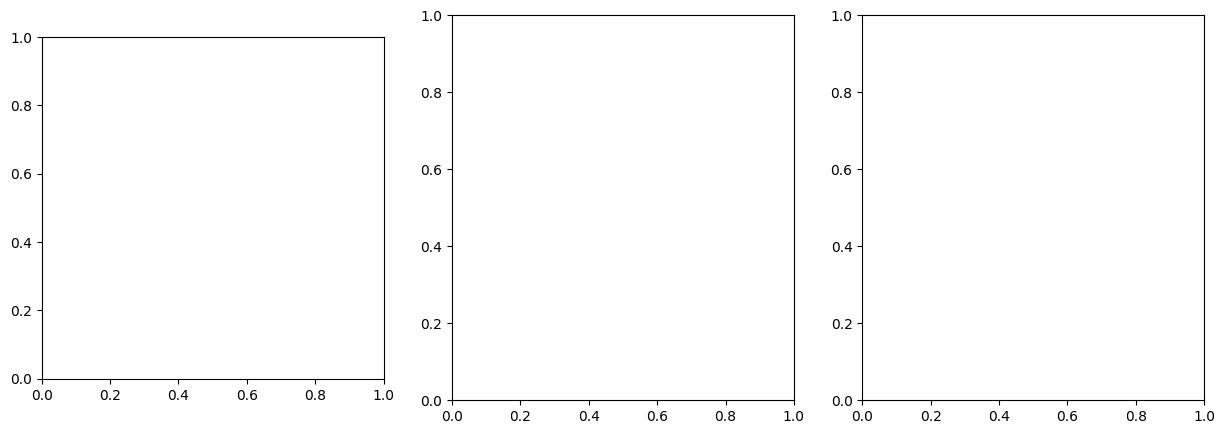

In [24]:
from matplotlib import pyplot as plt

# Instanciando o modelo GAN
gan = PaisagemGAN(generator=gene, discriminator=disc)
gan = gan.to(device)
gan.compile(g_loss=g_loss, d_loss=d_loss)

# Número de épocas
num_epochs = 35


# Loop de treinamento
print("Iniciar treinamento")
g_losses = []
d_losses = []
val_losses = []
for epoch in range(num_epochs):
    i = 0
    inicio = time.time()
    train_g_loss = 0.0
    train_d_loss = 0.0
    for batch in train_loader:
        real_images = normalize(batch[1].to(device))
        grey_images = normalize(batch[0].to(device))
        loss = gan.train_step(real_images, grey_images)
        i += 1
        train_g_loss += loss['g_loss']
        train_d_loss += loss['d_loss']
        real_images.cpu()
        grey_images.cpu()
    g_losses.append(train_g_loss/len(train_loader))
    d_losses.append(train_d_loss/len(train_loader))
    
    # Avaliação no conjunto de validação
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_real_images = normalize(val_batch[1].to(device))
            val_grey_images = normalize(val_batch[0].to(device))
            val_fake_images = gan.generator(val_grey_images)
            val_yhat_fake = gan.discriminator(val_fake_images)
            last_v_loss = g_loss(val_yhat_fake, val_fake_images, val_real_images)
            val_loss += last_v_loss.item()
            val_real_images.cpu()
            val_grey_images.cpu()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {loss['d_loss']:.4f}, g_loss: {loss['g_loss']:.4f}, val_loss: {val_loss:.4f}")
    fim = time.time()
    print(fim - inicio)

    if (epoch+1) % 5 == 0 or (epoch) == 0:
        save_checkpoint(gan.generator, gan.g_opt, epoch, batch, loss, filepath='/kaggle/working/gen.pth')
        save_checkpoint(gan.discriminator, gan.d_opt, epoch, batch, loss, filepath='/kaggle/working/disc.pth')

        # Desenhando evoluçao do treinamento
        # Convertendo as imagens geradas de 0-1 para 0-255
        gen_image = (loss['gen'][0].detach().cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')

        # Convertendo batch[0] e batch[1] de 0-1 para 0-255
        real_image1 = (batch[0][0].detach().cpu().numpy().squeeze()*255).astype('uint8')
        real_image2 = (batch[1][0].detach().cpu().numpy().transpose(1, 2, 0)*255 ).astype('uint8')

        # Plotando as três imagens lado a lado
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(real_image1)
        axes[0].set_title("Real Image 1")

        axes[1].imshow(real_image2)
        axes[1].set_title("Real Image 2")

        axes[2].imshow(gen_image)
        axes[2].set_title(f"Generated Image at Epoch {epoch + 1}")

        for ax in axes:
            ax.axis('off')  # Remove os eixos

        plt.show()

        # Desenhando evolução da validação
        # Convertendo as imagens geradas de 0-1 para 0-255
        gen_image = (val_fake_images[0].detach().cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')

        # Convertendo batch[0] e batch[1] de 0-1 para 0-255
        real_image1 = (val_grey_images[0].detach().cpu().numpy().squeeze()*255).astype('uint8')
        real_image2 = (val_real_images[0].detach().cpu().numpy().transpose(1, 2, 0)*255 ).astype('uint8')

        # Plotando as três imagens lado a lado
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(real_image1, cmap='gray')
        axes[0].set_title("Real Image 1")

        axes[1].imshow(real_image2)
        axes[1].set_title("Real Image 2")

        axes[2].imshow(gen_image)
        axes[2].set_title(f"Generated Image at Epoch {epoch + 1}")

        for ax in axes:
            ax.axis('off')

        plt.show()
        

print("Treinamento concluído!")


In [13]:
#torch.cuda.empty_cache()
print(val_losses)

[8.235966873168945, 8.104880719714695, 7.566074636247423, 7.727585665384928, 8.423988400565253, 7.777117167578803, 7.600813828574287, 7.583117983076307, 7.542600970798069, 7.549440728293525, 7.157434129714966, 7.406406195958455, 7.356189902623495, 7.649847014745077, 7.469735097885132, 7.582458469602797, 7.192126936382717, 7.205754068162706, 7.225237523184882, 7.289644463857015, 7.304311286078559, 7.558359824286567, 7.235311444600423, 7.610034396913316, 7.153232876459757, 7.370679791768392, 7.616324938668145, 7.421148390240139, 7.4200044631958, 7.139899656507704, 7.262660699420505, 7.165954822964139, 7.436315435833401, 7.2713229868147105, 7.191684701707628, 7.244011110729641, 7.344809532165527, 7.295557043287489, 7.43472646607293, 7.1065970738728845, 7.405883174472385, 7.237439563539293, 7.194000313017104, 7.264578527874416, 7.086265166600545, 7.073581435945299, 7.141798978381686, 7.300048107571072, 7.107680961820814, 7.106431743833753, 7.194342856936984, 7.327388991249932, 7.0372621112

In [14]:
import csv

# Caminho do arquivo onde as perdas serão salvas
loss_file_path = '/kaggle/working/losses.csv'

# Função para salvar as perdas em um arquivo CSV
def save_losses_to_csv(g_losses, d_losses, val_losses, file_path):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'G Loss', 'D Loss', 'Validation Loss'])
        for epoch, (g, d, val_loss) in enumerate(zip(g_losses, d_losses, val_losses), start=1):
            writer.writerow([epoch, g, d, val_loss])

# Salvar as perdas
save_losses_to_csv(g_losses, d_losses, val_losses, loss_file_path)

print(f"Losses saved to {loss_file_path}")

Losses saved to /kaggle/working/losses.csv
